In [1]:
# implement the dqn for me using pytorch and openai gym
import matplotlib.pyplot as plt
from gym import spaces
import json
"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

# get the cuda
# import optimimzer
import torch.optim as optim
import torch.nn.functional as F
import random
import math
from collections import namedtuple
from itertools import count
from IPython import display
from torch.autograd import Variable
from collections import deque
import time


In [2]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, output_dim)
        
    def forward(self, x):
        x = x.view(-1, input_dim)
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x)) 
        x = torch.relu(self.linear3(x))
        x = self.linear4(x)
        return x 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")
def int_to_tensor(x):
    return torch.tensor(x, dtype=torch.float32, device=device).unsqueeze(0)

Using cuda


sampled action : 2
Sampled observation


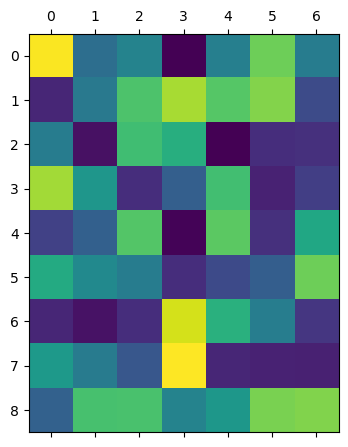

In [3]:
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
print(f"sampled action : {action_space.sample()}")
print("Sampled observation")
plt.matshow(observation_space.sample()[1,:,:])
plt.show()

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4
def action_preprocessor_m(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': bool(dyn.get_action()['confinement']), 
        'isolation': bool(dyn.get_action()['isolation']), 
        'hospital': bool(dyn.get_action()['hospital']), 
        'vaccinate': bool(dyn.get_action()['vaccinate']),
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = bool( 1 - dyn.get_action()['confinement'] ) 
    elif a == ACTION_ISOLATE:
        action['isolation'] = bool( 1 - dyn.get_action()['isolation'] )
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = bool( 1 - dyn.get_action()['vaccinate'] )
    elif a == ACTION_HOSPITAL:
        action['hospital'] = bool( 1 - dyn.get_action()['hospital'] )
        
    return action

def observation_preprocessor_m(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.power(np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = SCALE * np.power( np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolationed = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    hospitaled = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))

    return torch.Tensor(np.stack((infected, dead, confined, isolationed, hospitaled, vaccinated))).unsqueeze(0)

In [4]:
env_m = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_m,
            observation_preprocessor=observation_preprocessor_m,
            )

In [5]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward')) # define the transition tuple

class DQN_Agent(Agent):
    def __init__(self,  env:Env, epsilon:float = 0.7, batch_size: int = 2048, buffer_size: int = 20000, device = 'cuda', GAMMA : float = 0.9,
                 lr : float = 1e-5, policy_net = None, target_net = None, optimizer = None,
                # Additionnal parameters to be added here
                ):
        self.epsilon = epsilon
        self.env = env
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.memory_initial()
        self.device = device
        self.GAMMA = GAMMA
        self.lr = lr
        self.policy_net = policy_net
        self.target_net = target_net
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

    def save_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        torch.save(self.policy_net.state_dict(), savepath)
        pass

    def load_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())
        pass

    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    # the action function for Q3a
    def act(self, obs, temp_epsilon):
        # write the epsilon-greedy policy here
        if random.random() < temp_epsilon:
            return int_to_tensor( self.env.action_space.sample()).unsqueeze(0) 
        else:
            m = self.policy_net(obs.to(self.device)).max(1)[1].view(1, 1)
            return m # return the action with the highest q-value
    
    # the action functio for Q3b
    def act_decay(self, obs, epsilon0, epsilonmin, Tmax, t):
        temp_epsilon = np.max([epsilon0*(Tmax-t)/Tmax, epsilonmin])
        return self.act(obs, temp_epsilon)
        
    def memory_initial(self):
        # initialize the memory
        self.memory = deque([],maxlen= self.buffer_size) # define the memory as a deque of size capacity

    def memory_push(self, transition):
        # push a transition into the memory
        self.memory.append(transition)

    def memory_sample(self):
        # sample a batch from memory
        return random.sample(self.memory, self.batch_size)
    
    def memory_len(self):
        # return the length of the memory
        return len(self.memory)
    
    def optimize_model(self, train = True):
        # This is where one would define the optimization step of an RL algorithm
        if self.memory_len() < self.batch_size:
            return 0
        transitions = self.memory_sample()

        batch = Transition(*zip(*transitions)) # unzip the batch

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device= self.device, dtype=torch.bool).to(device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)

        state_batch = torch.cat(batch.state).to(device)
        
        action_batch = torch.cat(batch.action).to(device)
        reward_batch = torch.cat(batch.reward).squeeze().to(device)

        action_batch = action_batch.long()
        state_action_values = self.policy_net(state_batch).gather(1, action_batch).to(device)
        next_state_values = torch.zeros(self.batch_size, device= self.device)


        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch
                
        criterion = nn.MSELoss() # define the loss function

        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        if train == True:
            # Optimize the model
            self.optimizer.zero_grad()
            loss.backward()
            # In-place gradient clipping
            torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100) 
            self.optimizer.step()
        return loss.item()
    
    def update_target_model(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

In [10]:
random_seed = 42 
BATCH_SIZE = 2048
GAMMA = 0.9
LR = 1e-3
input_dim = 6 * dyn.n_cities * dyn.env_step_length

state, info = env_m.reset(42)


# Initialize policy and target network
policy_net_m = DQN(input_dim, 5).to(device)
target_net_m = DQN(input_dim, 5).to(device)
# Initialize the target network to be the same as the policy network
target_net_m.load_state_dict(policy_net_m.state_dict()) 


DQNagent_m = DQN_Agent(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net_m, target_net=target_net_m)



def one_episode_decay(env,agent,random_seed, epsilon0, epsilonmin, Tmax, t):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act_decay(state, epsilon0, epsilonmin, Tmax, t)
        next_state, reward, done, _ = env.step(action)
        agent.memory_push(Transition(state, action, next_state, reward))
        state = next_state
        total_reward += reward
        loss = agent.optimize_model()
        total_loss += loss
    
    return total_reward.item(), total_loss


def eval_one(env,agent, random_seed):
    state, _ = env.reset(random_seed)
    done = False
    total_reward = 0
    total_loss = 0

    while not done:
        action = agent.act(state,0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward
        loss = agent.optimize_model(train = False)
        total_loss += loss
    
    return total_reward.item(), total_loss



def train_Q4(experiment_id):
    #print(experiment id)
    print(f"Experiment {experiment_id}")
    print('-------------------------------------------')

    # Initialize policy and target network
    policy_net = DQN(input_dim, 5).to(device)
    target_net = DQN(input_dim, 5).to(device)
    # Initialize the target network to be the same as the policy network
    target_net.load_state_dict(policy_net.state_dict()) 

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    DQNagent = DQN_Agent(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                        policy_net=policy_net, target_net=target_net, optimizer=optimizer)
    
    train_loss_trace = []
    train_reward_trace = []
    eval_loss_trace = []
    eval_reward_trace = []

    best = -np.inf

    for i in range(1,501):
        reward, loss = one_episode_decay(env_m,DQNagent,i,0.7,0.2,500,i)
        train_loss_trace.append(loss)
        train_reward_trace.append(reward)
        #print(f"Episode {i} : reward {reward}, loss {loss}")
        if i % 5 == 0:
            DQNagent.update_target_model()
        if i % 50 == 0 :
            testlist = random.sample(range(100), 20) 
            tuple_list = np.array([eval_one(env_m,DQNagent,m) for m in range(20)])
            eval_losss = np.mean(tuple_list,axis = 0)[1]
            eval_rewards = np.mean(tuple_list,axis = 0)[0]

            eval_loss_trace.append(eval_losss)
            eval_reward_trace.append(eval_rewards)
            train_loss = np.mean(train_loss_trace[i-50:i-1])
            train_reward = np.mean(train_reward_trace[i-50:i-1])
            
            if eval_rewards > best:
                best = eval_rewards
                # save the model in this experiment_id
                torch.save(DQNagent.policy_net.state_dict(), f"DQN_best_Q4_{experiment_id}.pth") 
            print(f"Episode {i} : train_reward {train_reward}, train_loss {train_loss}")
            print(f"Episode {i} : eval_reward {eval_rewards}, eval_loss {eval_losss}")

    # record the train_loss trace in corresponding experiment_id
    with open(f'Q4_train_loss_{experiment_id}.json', 'w') as f: json.dump(train_loss_trace, f)
    with open(f'Q4_train_reward_{experiment_id}.json', 'w') as f: json.dump(train_reward_trace, f)
    with open(f'Q4_eval_loss_{experiment_id}.json', 'w') as f: json.dump(eval_loss_trace, f)
    with open(f'Q4_eval_reward_{experiment_id}.json', 'w') as f: json.dump(eval_reward_trace, f)

In [11]:
def experiment_Q4():
    for i in range(1,4):
        train_Q4(i)
experiment_Q4()

Experiment 1
-------------------------------------------
Episode 50 : train_reward -151.77965784559444, train_loss 0.0
Episode 50 : eval_reward -202.73003425598145, eval_loss 0.0
Episode 100 : train_reward -126.51512268003152, train_loss 6045.264604529556
Episode 100 : eval_reward -105.74877787828446, eval_loss 9486.263168334961
Episode 150 : train_reward -114.83458574572388, train_loss 8631.482845072844
Episode 150 : eval_reward -95.52459039688111, eval_loss 9091.007775878907
Episode 200 : train_reward -95.33554420665818, train_loss 8208.360301737883
Episode 200 : eval_reward -83.0589476108551, eval_loss 8043.63638458252
Episode 250 : train_reward -68.68206208579394, train_loss 7043.004427540059
Episode 250 : eval_reward -41.50882674455643, eval_loss 6202.820746612549
Episode 300 : train_reward -57.62676511492048, train_loss 5345.780079432896
Episode 300 : eval_reward -41.84131993167102, eval_loss 4698.036920928955
Episode 350 : train_reward -46.022930321644765, train_loss 4302.155021

In [13]:
def plot_pic(log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

    from matplotlib.ticker import MultipleLocator
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

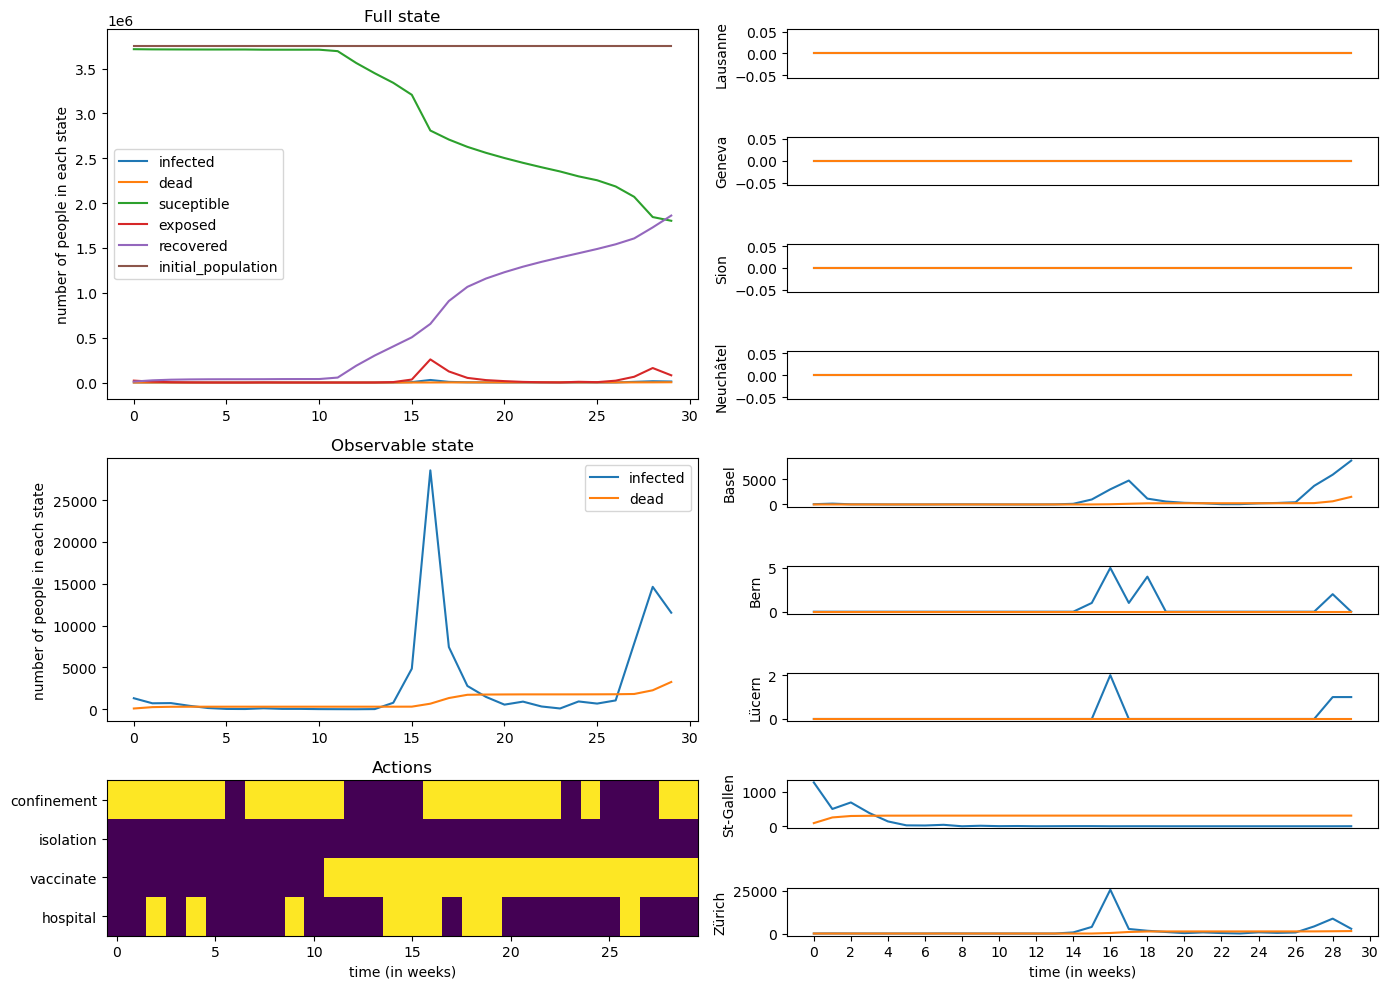

In [20]:
testagent = DQN_Agent(env_m, epsilon=0.7, batch_size=BATCH_SIZE, buffer_size=20000, GAMMA=GAMMA,lr = LR, device=device ,
                    policy_net=policy_net_m, target_net=target_net_m)
testagent.load_model("DQN_best_Q4.pth")
log2 = []
finished = False
obs, info = env_m.reset(0)

while not finished:
    action = testagent.act(obs,0.4)
    obs, R, finished, info = env_m.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break

plot_pic(log2)

In [28]:
one_episode_decay(env_m,DQNagent_m,1,0.7,0.2,500,450)

(-120.44697570800781, 6844.538772583008)

In [22]:
def dqn_plot(env, agent):
    deaths_list, rewards_list, conf_days, isol_days, hosp_days, vacc_days = [],[],[],[],[],[]
    seeds = range(20)
    for i in range(20):
        total_deaths = 0
        total_rewards = 0
        total_conf = 0
        total_isol = 0
        total_hosp = 0
        total_vacc = 0
        
        finished = False
        obs, info = env.reset(seeds[i])

        confine = False
        isolate = False
        hospital = False
        vaccinate = False
  
        while not finished:
            action = agent.act(obs,0)
            
            if action.item() == 0:
                pass
            if action.item() == ACTION_CONFINE:
                confine = bool(1 - int(confine))
            if action.item() == ACTION_ISOLATE:
                isolate = bool(1 - int(isolate))
            if action.item() == ACTION_HOSPITAL:
                hospital = bool(1 - int(hospital))
            if action.item() == ACTION_VACCINATE:
                vaccinate = bool(1 - int(vaccinate))

            total_conf += confine * 7
            total_isol += isolate * 7
            total_hosp += hospital * 7
            total_vacc += vaccinate * 7

            #if action.item() == 1: total_conf += 1
            obs, R, finished, info = env.step(action)
            
            total_rewards += float(R)
            if finished:
                deaths_list.append(info.total.dead)
                break
        
        conf_days.append(total_conf)
        isol_days.append(total_isol)
        hosp_days.append(total_hosp)
        vacc_days.append(total_vacc)
        rewards_list.append(total_rewards)

    return deaths_list, rewards_list, conf_days

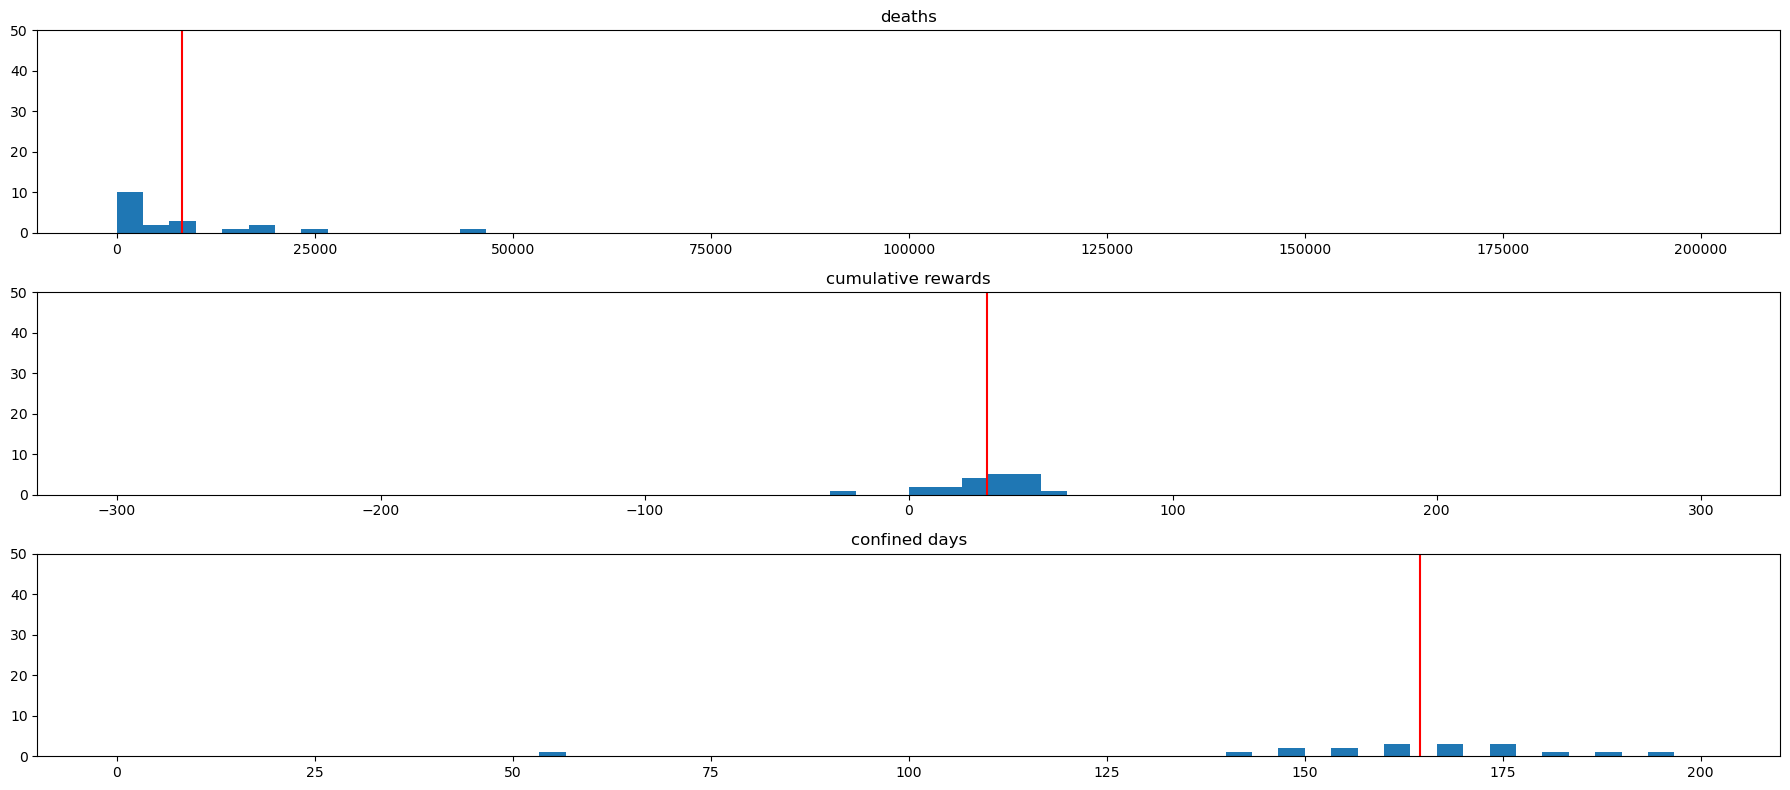

Average death number: 8291.55
Average number of confined days: 164.5
Average cumulative reward: 29.596037690748926


In [23]:
deaths, rewards, conf_days  = dqn_plot(env_m, DQNagent_m)

fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (0,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
    
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')

fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')